# Recovery of gold from ore

Prepare a prototype machine learning model for Zifra. The company develops solutions for the efficient operation of industrial enterprises.

The model should predict the recovery rate of gold from gold ore. Use data with mining and cleaning parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

You need:

- Prepare data
 - Open files and examine them.
 - Check that the enrichment efficiency is calculated correctly. Calculate it on the training sample for the feature rougher.output.recovery. Find the MAE between your calculations and the feature value. Describe the findings.
 - Analyze features that are not available in the test sample. What are these parameters? What type are they?
 - Perform data preprocessing.
- Analyze data
 - See how the concentration of metals (Au, Ag, Pb) changes at different stages of purification. Describe the findings.
 - Compare the size distributions of raw material granules on the training and test samples. If the distributions are very different from each other, the estimation of the model will be wrong.
 - Explore the total concentration of all substances at different stages: in raw materials, in rough and final concentrates.
- Build the model
 - Write a function to calculate the final sMAPE.
 - Train different models and evaluate their quality by cross-validation. Choose the best model and test it on a test set. Describe the findings.

The formulas for quality metrics:

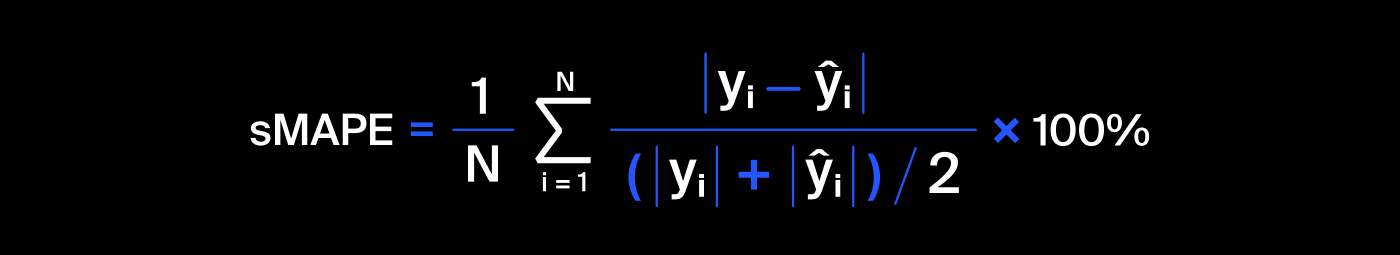

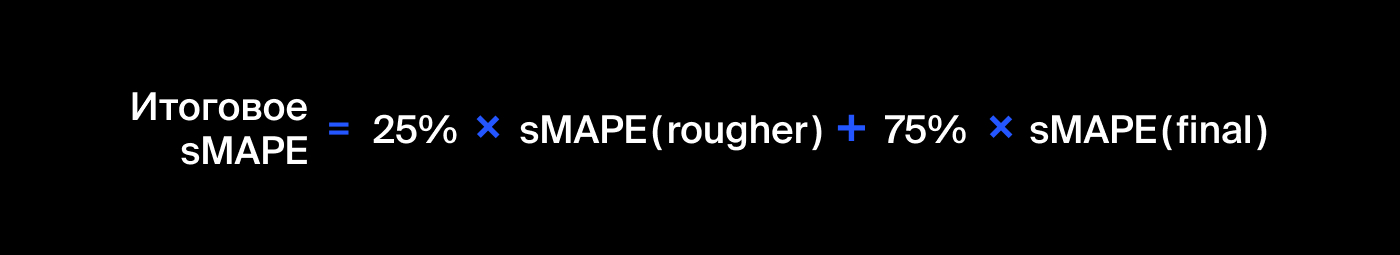

## Data preparation

### Examining files

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#loading data
path ='/Users/vzuga/Documents/jupyter/'

try:
    df_full = pd.read_csv('gold_recovery_full_new.csv') 
    df_test = pd.read_csv('gold_recovery_test_new.csv') 
    df_train = pd.read_csv('gold_recovery_train_new.csv')
except:
    df_full = pd.read_csv(path+'/datasets/gold_recovery_full_new.csv')
    df_test = pd.read_csv(path+'/datasets/gold_recovery_test_new.csv')
    df_train = pd.read_csv(path+'/datasets/gold_recovery_train_new.csv')

I will write a function that will show brief information about the file, display the first 5 lines, check for duplicates and gaps, as well as the number of unique date values.

In [3]:
def data_check(data):
    data.info()
    print()
    display(data.head())
    print()
    print('Duplicates:', data.duplicated().sum())
    print()
    print('Missing values')
    print(data.isna().mean())
    print()
    print('Unique values of date:', len(data['date'].unique()))
        

#### Full

In [4]:
data_check(df_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Duplicates: 0

Missing values
date                                          0.000000
final.output.concentrate_ag                   0.000051
final.output.concentrate_pb                   0.000051
final.output.concentrate_sol                  0.010854
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.000051
secondary_cleaner.state.floatbank5_b_air      0.000051
secondary_cleaner.state.floatbank5_b_level    0.000051
secondary_cleaner.state.floatbank6_a_air      0.000103
secondary_cleaner.state.floatbank6_a_level    0.000051
Length: 87, dtype: float64

Unique values of date: 19439


#### Test

In [5]:
data_check(df_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333



Duplicates: 0

Missing values
date                                          0.000000
primary_cleaner.input.sulfate                 0.000756
primary_cleaner.input.depressant              0.000945
primary_cleaner.input.feed_size               0.000000
primary_cleaner.input.xanthate                0.000756
primary_cleaner.state.floatbank8_a_air        0.000000
primary_cleaner.state.floatbank8_a_level      0.000000
primary_cleaner.state.floatbank8_b_air        0.000000
primary_cleaner.state.floatbank8_b_level      0.000000
primary_cleaner.state.floatbank8_c_air        0.000000
primary_cleaner.state.floatbank8_c_level      0.000000
primary_cleaner.state.floatbank8_d_air        0.000000
primary_cleaner.state.floatbank8_d_level      0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.000000
rougher.input.feed_rate                       0.000567
rougher.input.feed_size                       0.000189
rougher.input.feed_sol            

#### Train

In [6]:
data_check(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691



Duplicates: 0

Missing values
date                                          0.000000
final.output.concentrate_ag                   0.000071
final.output.concentrate_pb                   0.000071
final.output.concentrate_sol                  0.014913
final.output.concentrate_au                   0.000000
                                                ...   
secondary_cleaner.state.floatbank5_a_level    0.000071
secondary_cleaner.state.floatbank5_b_air      0.000071
secondary_cleaner.state.floatbank5_b_level    0.000071
secondary_cleaner.state.floatbank6_a_air      0.000141
secondary_cleaner.state.floatbank6_a_level    0.000071
Length: 87, dtype: float64

Unique values of date: 14149


#### Conclusions
* no problems with names and data type
* no obvious duplicates found
* there is a small (about 1% or less) number of gaps
* in the date column, all values are unique, maybe this will come in handy in the future
* there are fewer features in the test sample

### Enrichment efficiency

Enrichment efficiency is calculated by the formula

__С*(F-T) / F*(C-T)__,

where

C - is the proportion of gold in the concentrate after flotation/refining;

F - is the share of gold in the raw material/concentrate before flotation/refining;

T - is the proportion of gold in tailings after flotation/cleaning.

In [7]:
# function to calculate recovery
def recovery(C, F, T):
    R = C*(F-T)/(F*(C-T))*100
    return R

For the rougher.output.recovery feature, C is rougher.output.concentrate_au, F is rougher.input.feed_au, and T is rougher.output.tail_au.

I will check the function on the first value in the training sample.

In [8]:
#existing recovery
df_train.loc[0, 'rougher.output.recovery']

87.10776292825425

In [9]:
#calculated recovery
recovery(df_train.loc[0, 'rougher.output.concentrate_au'], df_train.loc[0, 'rougher.input.feed_au'], df_train.loc[0, 'rougher.output.tail_au'])

87.10776292825425

The function is working properly. I will calculate the recovery for the training sample and compare it with the given one and calculate the average absolute deviation.

In [10]:
recovery_calc = df_train.apply(
    lambda x: recovery(x['rougher.output.concentrate_au'], x['rougher.input.feed_au'], 
                       x['rougher.output.tail_au']), 
    axis=1)

In [11]:
recovery_calc

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64

In [12]:
df_train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Name: rougher.output.recovery, Length: 14149, dtype: float64

In [13]:
print('MAE:', mean_absolute_error(df_train['rougher.output.recovery'], recovery_calc))

MAE: 9.73512347450521e-15


### Conclusions

* several values show that the enrichment efficiency is calculated correctly
* the average absolute deviation between the calculated and given efficiency is almost zero, which means that there is practically no difference between these values.

### Features not available in the test set

I will create a Series with columns that are not in the test set.

In [14]:
missing_features = pd.concat([pd.Series(df_train.columns), pd.DataFrame(df_test.columns)], axis=1)
missing_features.columns=['train', 'test']
missing_features = missing_features[missing_features['test'].isna()]['train'].reset_index(drop=True)

In [15]:
missing_features

0                rougher.state.floatbank10_a_air
1              rougher.state.floatbank10_a_level
2                rougher.state.floatbank10_b_air
3              rougher.state.floatbank10_b_level
4                rougher.state.floatbank10_c_air
5              rougher.state.floatbank10_c_level
6                rougher.state.floatbank10_d_air
7              rougher.state.floatbank10_d_level
8                rougher.state.floatbank10_e_air
9              rougher.state.floatbank10_e_level
10               rougher.state.floatbank10_f_air
11             rougher.state.floatbank10_f_level
12              secondary_cleaner.output.tail_ag
13              secondary_cleaner.output.tail_pb
14             secondary_cleaner.output.tail_sol
15              secondary_cleaner.output.tail_au
16      secondary_cleaner.state.floatbank2_a_air
17    secondary_cleaner.state.floatbank2_a_level
18      secondary_cleaner.state.floatbank2_b_air
19    secondary_cleaner.state.floatbank2_b_level
20      secondary_cl

In the test sample, there are mainly no parameters characterizing the current state of the stage, as well as parameters of tailings of the second stage of cleaning.

Since these parameters are not in the test sample, they will have to be removed from the training sample as well.

It is known from the conditions of the problem that there are no target features in the test sample.

### Data preprocessing

I'll fill in the blanks.

I'll look at the date column.

In [16]:
df_train['date'].head()

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
Name: date, dtype: object

In [17]:
df_train['date'].tail()

14144    2018-08-18 06:59:59
14145    2018-08-18 07:59:59
14146    2018-08-18 08:59:59
14147    2018-08-18 09:59:59
14148    2018-08-18 10:59:59
Name: date, dtype: object

All entries in the date column are unique and you can see that they go chronologically. Since the number of gaps is small (no more than 2%), I will fill in the gaps with the previous values.

In [18]:
df_train = df_train.fillna(method="ffill")

df_test = df_test.fillna(method="ffill")

In [19]:
df_train.isna().mean()

date                                          0.0
final.output.concentrate_ag                   0.0
final.output.concentrate_pb                   0.0
final.output.concentrate_sol                  0.0
final.output.concentrate_au                   0.0
                                             ... 
secondary_cleaner.state.floatbank5_a_level    0.0
secondary_cleaner.state.floatbank5_b_air      0.0
secondary_cleaner.state.floatbank5_b_level    0.0
secondary_cleaner.state.floatbank6_a_air      0.0
secondary_cleaner.state.floatbank6_a_level    0.0
Length: 87, dtype: float64

## Data analysis

### Concentration of metals (Au, Ag, Pb) at various purification steps

In the process of processing, the ore goes through various stages:

* __rougher.input.feed_au__ - _primary concentration_

* __rougher.output.concentrate_au__ - _rougher concentrate_

* __primary_cleaner.output.concentrate_au__ - _concentration after primary cleaning_

* __final.output.concentrate_au__ - _final concentration_

#### Gold (Au)

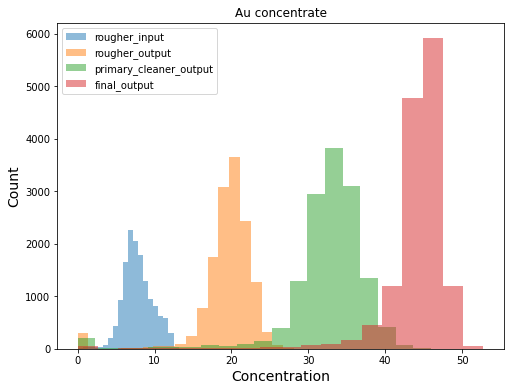

In [20]:
plt.figure(figsize=(8,6))
plt.hist(df_train['rougher.input.feed_au'], bins=20, alpha=0.5, label="rougher_input")
plt.hist(df_train['rougher.output.concentrate_au'], bins=20, alpha=0.5, label="rougher_output")
plt.hist(df_train['primary_cleaner.output.concentrate_au'], bins=20, alpha=0.5, label="primary_cleaner_output")
plt.hist(df_train['final.output.concentrate_au'], bins=20, alpha=0.5, label="final_output")
plt.xlabel("Concentration", size=14)
plt.ylabel("Count", size=14)
plt.title("Au concentrate")
plt.legend(loc='upper left')

#### Silver (Ag)

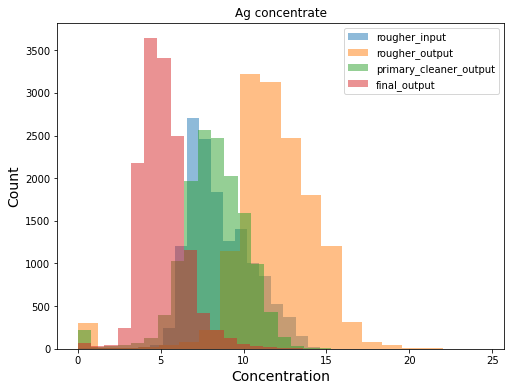

In [21]:
plt.figure(figsize=(8,6))
plt.hist(df_train['rougher.input.feed_ag'], bins=20, alpha=0.5, label="rougher_input")
plt.hist(df_train['rougher.output.concentrate_ag'], bins=20, alpha=0.5, label="rougher_output")
plt.hist(df_train['primary_cleaner.output.concentrate_ag'], bins=20, alpha=0.5, label="primary_cleaner_output")
plt.hist(df_train['final.output.concentrate_ag'], bins=20, alpha=0.5, label="final_output")
plt.xlabel("Concentration", size=14)
plt.ylabel("Count", size=14)
plt.title("Ag concentrate")
plt.legend(loc='upper right')

#### Lead (Pb)

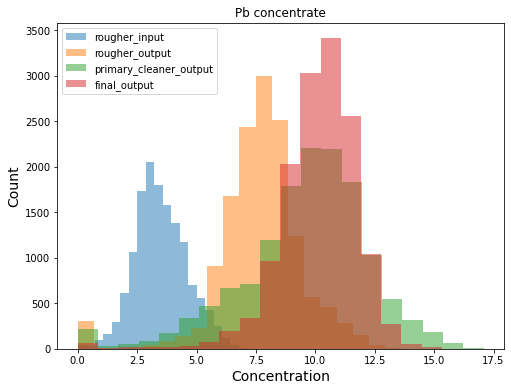

In [22]:
plt.figure(figsize=(8,6))
plt.hist(df_train['rougher.input.feed_pb'], bins=20, alpha=0.5, label="rougher_input")
plt.hist(df_train['rougher.output.concentrate_pb'], bins=20, alpha=0.5, label="rougher_output")
plt.hist(df_train['primary_cleaner.output.concentrate_pb'], bins=20, alpha=0.5, label="primary_cleaner_output")
plt.hist(df_train['final.output.concentrate_pb'], bins=20, alpha=0.5, label="final_output")
plt.xlabel("Concentration", size=14)
plt.ylabel("Count", size=14)
plt.title("Pb concentrate")
plt.legend(loc='upper left')

In [23]:
metal_conc = pd.DataFrame(data={'stage':['rougher_input', 'rougher_output', 'primary_cleaner_output', 'final_output'],                               
'Au':[df_train['rougher.input.feed_au'].mean(), df_train['rougher.output.concentrate_au'].mean(), 
      df_train['primary_cleaner.output.concentrate_au'].mean(), df_train['final.output.concentrate_au'].mean()],
'Ag':[df_train['rougher.input.feed_ag'].mean(), df_train['rougher.output.concentrate_ag'].mean(), 
      df_train['primary_cleaner.output.concentrate_ag'].mean(), df_train['final.output.concentrate_ag'].mean()],
'Pb':[df_train['rougher.input.feed_pb'].mean(), df_train['rougher.output.concentrate_pb'].mean(), 
      df_train['primary_cleaner.output.concentrate_pb'].mean(), df_train['final.output.concentrate_pb'].mean()]})
metal_conc

,stage,Au,Ag,Pb
0,rougher_input,7.866577,8.579195,3.505465
1,rougher_output,19.439958,11.775812,7.664555
2,primary_cleaner_output,32.386836,8.200916,9.568544
3,final_output,44.003792,5.141921,10.132848


* the concentration of gold increases at each stage of processing - the mixture is enriched
* the concentration of silver is maximum after flotation treatment and drops in the final stage
* there is a slight increase in lead concentration

### Raw material granule sizes

I will compare the size distributions of raw material granules on the training and test samples.

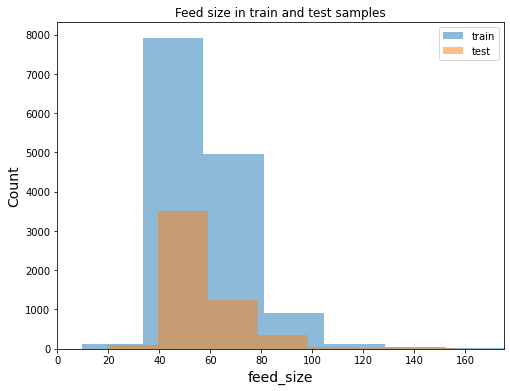

In [24]:
plt.figure(figsize=(8,6))
plt.hist(df_train['rougher.input.feed_size'], bins=20, alpha=0.5, label="train")
plt.hist(df_test['rougher.input.feed_size'], bins=20, alpha=0.5, label="test")
plt.xlim([0, 175])
plt.xlabel("feed_size", size=14)
plt.ylabel("Count", size=14)
plt.title("Feed size in train and test samples")
plt.legend(loc='upper right')

In [25]:
print('train:', df_train['rougher.input.feed_size'].mean())

train: 60.23985599255732


In [26]:
print('test:', df_test['rougher.input.feed_size'].mean())

test: 55.952754028895136


The sizes of raw material granules in the two samples are close.

### Total concentration

I will calculate the total concentration in the initial data.

In [27]:
#total concentration in raw materials
df_full['feed_conc'] = df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_pb'] + \
df_full['rougher.input.feed_sol'] + df_full['rougher.input.feed_au']

#total concentration in crude concentrate
df_full['rougher_conc'] = df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_pb'] + \
df_full['rougher.output.concentrate_sol'] + df_full['rougher.output.concentrate_au']

#total concentration in the final concentrate
df_full['final_conc'] = df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_pb'] + \
df_full['final.output.concentrate_sol'] + df_full['final.output.concentrate_au']

I will look at the total zero concentration:

In [28]:
len(df_full[(df_full['feed_conc']==0)|(df_full['rougher_conc']==0)|(df_full['final_conc']==0)])

490

The zero concentration of all substances in any of the stages is obviously an error in the data. I will delete this data in both selection by date.

In [29]:
#set date as index
df_full = df_full.set_index('date')
df_test = df_test.set_index('date')
df_train = df_train.set_index('date')

In [30]:
#drop zero values
df_train = df_train[~((df_full['feed_conc']==0)|(df_full['rougher_conc']==0)|(df_full['final_conc']==0))]

df_test = df_test[~((df_full['feed_conc']==0)|(df_full['rougher_conc']==0)|(df_full['final_conc']==0))]

I'll look at the distribution of the total concentration values.

<AxesSubplot:>

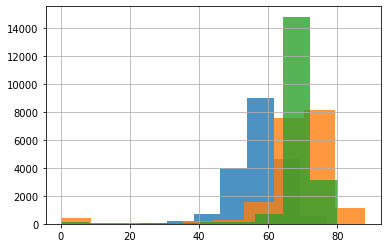

In [31]:
df_full['feed_conc'].hist(alpha=.8)
df_full['rougher_conc'].hist(alpha=.8)
df_full['final_conc'].hist(alpha=.8)

In addition to zeros, I did not find other anomalous values.

### Conclusions:
* at each subsequent stage of processing, the concentration of gold increases
* the sizes of raw material granules in the test and training samples are close
* detected and removed values of zero total concentration

## Model

### Function for calculating sMAPE

I will divide the data into features and targets.

In [32]:
features_train = df_train.loc[: ,df_test.columns]
target_train = df_train[['rougher.output.recovery', 'final.output.recovery']]

features_test = df_test
target_test = df_full.loc[df_test.index][['rougher.output.recovery', 'final.output.recovery']]

I will write a function to calculate the final sMAPE.

In [33]:
def smape(target, predict):
    target = target.to_numpy()
    smape_rougher = np.sum(np.abs(target[:, 0] - predict[:, 0]) / (np.abs(target[:, 0])*.5 + np.abs(predict[:, 0])*.5))/len(target)
    smape_final = np.sum(np.abs(target[:, 1] - predict[:, 1]) / (np.abs(target[:, 1])*.5 + np.abs(predict[:, 1])*.5))/len(target)
    return (smape_rougher*25 + smape_final*75)

In [34]:
#check
smape(target_test, target_test.to_numpy())

0.0

In the case of sMAPE, the smaller the value, the better the model. I will make a scorer for evaluating models with the greater_is_better=False parameter. The greater_is_better=False parameter adds a minus in front of the score value, since the maximization of a negative metric is equal to the minimization of the original one.

In [35]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Linear Regression

In [36]:
model = make_pipeline(StandardScaler(), LinearRegression())
scores = -1*cross_val_score(model, features_train, target_train, cv=5, scoring=smape_scorer)
print('sMAPE for LinearRegression:', scores.mean())

sMAPE for LinearRegression: 10.0596020690936


### DecisionTreeRegressor

In [37]:
model = make_pipeline(StandardScaler(), DecisionTreeRegressor())
params = {'decisiontreeregressor__max_depth':list(range(1, 5))}
grid = GridSearchCV(model, params, cv = 5, scoring=smape_scorer)
grid.fit(features_train, target_train)

print('Params:', grid.best_params_)
print('sMAPE for DecisionTreeRegressor:',(grid.best_score_)*-1)

Params: {'decisiontreeregressor__max_depth': 1}
sMAPE for DecisionTreeRegressor: 8.987481089659116


### RandomForestRegressor

In [38]:
model = make_pipeline(StandardScaler(), RandomForestRegressor())
params = {'randomforestregressor__max_depth':list(range(1, 5)), 
         'randomforestregressor__n_estimators':list(range(10, 31, 10))}
grid = GridSearchCV(model, params, cv = 5, scoring=smape_scorer)
grid.fit(features_train, target_train)

print('Params:', grid.best_params_)
print('sMAPE for RandomForest:',(grid.best_score_)*-1)

Params: {'randomforestregressor__max_depth': 3, 'randomforestregressor__n_estimators': 20}
sMAPE for RandomForest: 8.672620246055715


The minimum sMAPE metric was obtained for the random forest model.

I will check the model on a test sample.

In [39]:
model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=10, max_depth=3))
model.fit(features_train, target_train)
print('sMAPE for test set:', smape(target_test, model.predict(features_test)))

sMAPE for test set: 7.064482507813411


I will check the model for adequacy.

In [40]:
model_dummy = make_pipeline(StandardScaler(), DummyRegressor(strategy='median'))
scores = -1*cross_val_score(model_dummy, features_train, target_train, cv=5, scoring=smape_scorer)
print('sMAPE for random model:', scores.mean())

sMAPE for random model: 9.800868954337108


In [41]:
model_dummy.fit(features_train, target_train)
print('sMAPE for random model on test set:', smape(target_test, model_dummy.predict(features_test)))

sMAPE for random model on test set: 7.363660673394497


### Conclusions:
* calculated sMAPE metric for various models
* the quality of the models was assessed using cross-validation
* the smallest value of the sMAPE metric was obtained for the random forest model
* the model is checked for adequacy